In [1]:
from pathlib import Path
import pandas as pd
from previous_chapters import (
    download_and_unzip_spam_data,
    create_balanced_dataset,
    random_split
)

In [2]:
url = \
"https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"

zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(
    data_file_path, sep="\t", header=None, names=["Label", "Text"]
)

balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [4]:
import torch
from torch.utils.data import Dataset
import tiktoken
from previous_chapters import SpamDataset

tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset("validation.csv",
    max_length=train_dataset.max_length, tokenizer=tokenizer
)
test_dataset = SpamDataset(
    "test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer
)

In [5]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [6]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [7]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [8]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel
from previous_chapters import load_weights_into_gpt



In [9]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [10]:
from previous_chapters import generate_text_simple
from previous_chapters import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [11]:
# prepare the model for classification fine-tuning by replacing output layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [12]:
from previous_chapters import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


## Parameter-efficient fine-tuning with LoRA

In [13]:
import math

# The rank governs the inner dimension of matrices A and B
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
        
    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [14]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
        
    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [15]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            replace_linear_with_lora(module, rank, alpha)
            

In [16]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

Total trainable parameters before: 124,441,346


In [18]:
for param in model.parameters():
    param.requires_grad = False
    
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters after: 0


In [19]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [21]:
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [24]:
# Fine-tuning a model with LoRA layers

import time
from previous_chapters import train_classifier_simple

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.396, Val loss 0.364
Ep 1 (Step 000100): Train loss 0.111, Val loss 0.229
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.135, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.008, Val loss 0.051
Ep 2 (Step 000250): Train loss 0.022, Val loss 0.178
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.082, Val loss 0.053
Ep 3 (Step 000350): Train loss 0.019, Val loss 0.130
Training accuracy: 100.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.004, Val loss 0.142
Ep 4 (Step 000450): Train loss 0.005, Val loss 0.023
Ep 4 (Step 000500): Train loss 0.000, Val loss 0.119
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.009, Val loss 0.183
Ep 5 (Step 000600): Train loss 0.017, Val loss 0.015
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 8.80 m

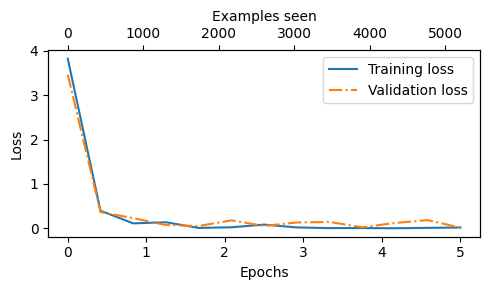

In [25]:
from previous_chapters import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(
epochs_tensor, examples_seen_tensor,
train_losses, val_losses, label="loss"
)

In [27]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.90%
Validation accuracy: 96.64%
Test accuracy: 96.67%


In [28]:
def classify_review(
    text, model, tokenizer, device, max_length=None,
    pad_token_id=50256):
    
    model.eval()
    
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]
    
    input_ids = input_ids[:min(
        max_length, supported_context_length
    )]
    
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    
    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)
    
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    return "spam" if predicted_label == 1 else "not spam"

In [29]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [30]:
text_2 = (
"Hey, just wanted to check if we're still on"
" for dinner tonight? Let me know!"
)

print(classify_review(
text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam
